In [ ]:
import pandas as pd
from sklearn.neighbors import LocalOutlierFactor
import matplotlib.pyplot as plt
from numpy import where

In [ ]:
data = pd.read_csv("Traffic_train.csv")
print(data.head())

   Delay  Code
0  15000   302
1      0   302
2      0   302
3  11000   302
4  19000   302


In [ ]:
print(data['Code'].unique())

[302 200 404 400 201 500 204]


In [ ]:
data['Code'].value_counts()

200    5918
201     952
400     662
404     314
204     172
500      36
302      35
Name: Code, dtype: int64

In [ ]:
one_hot_encoded_data = pd.get_dummies(data, columns = ['Code'])
print(one_hot_encoded_data)

      Delay  Code_200  Code_201  ...  Code_400  Code_404  Code_500
0     15000         0         0  ...         0         0         0
1         0         0         0  ...         0         0         0
2         0         0         0  ...         0         0         0
3     11000         0         0  ...         0         0         0
4     19000         0         0  ...         0         0         0
...     ...       ...       ...  ...       ...       ...       ...
8084  13000         1         0  ...         0         0         0
8085  14000         1         0  ...         0         0         0
8086  21000         1         0  ...         0         0         0
8087  15000         1         0  ...         0         0         0
8088  17000         1         0  ...         0         0         0

[8089 rows x 8 columns]


In [ ]:
df = one_hot_encoded_data[["Delay", "Code_200", "Code_201", "Code_204", "Code_302", "Code_400", "Code_404", "Code_500"]]

In [ ]:
model = LocalOutlierFactor(n_neighbors=20, novelty=True, contamination=0.1)
model.fit(df)

LocalOutlierFactor(contamination=0.1, novelty=True)

In [ ]:
data2 = pd.read_csv("Traffic_test3.csv")
one_hot_encoded_data2 = pd.get_dummies(data2, columns = ['Code'])
df2 = one_hot_encoded_data2[["Delay", "Code_200", "Code_201", "Code_204", "Code_302", "Code_400", "Code_404", "Code_500","Y"]]

In [ ]:
df2

,Delay,Code_200,Code_201,Code_204,Code_302,Code_400,Code_404,Code_500,Y
0,11000,1,0,0,0,0,0,0,1
1,14000,1,0,0,0,0,0,0,1
2,23000,1,0,0,0,0,0,0,1
3,23000,0,1,0,0,0,0,0,1
4,17000,0,0,1,0,0,0,0,1
...,...,...,...,...,...,...,...,...,...
98,19000,1,0,0,0,0,0,0,1
99,19000,1,0,0,0,0,0,0,1
100,72000,1,0,0,0,0,0,0,-1
101,26000,1,0,0,0,0,0,0,1


In [ ]:
X_test=df2[["Delay", "Code_200", "Code_201", "Code_204", "Code_302", "Code_400", "Code_404", "Code_500"]]
y_test=df2[["Y"]]

In [ ]:

y_pred = model.predict(X_test)
y_pred

/usr/local/lib/python3.7/dist-packages/sklearn/base.py:451: UserWarning: X does not have valid feature names, but LocalOutlierFactor was fitted with feature names
  "X does not have valid feature names, but"


array([ 1,  1,  1,  1, -1,  1,  1,  1,  1,  1,  1,  1,  1,  1, -1,  1,  1,
        1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,
        1,  1,  1,  1,  1,  1,  1,  1,  1,  1, -1,  1,  1,  1,  1,  1,  1,
        1,  1,  1, -1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,
        1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,
       -1,  1,  1, -1,  1,  1, -1,  1,  1, -1,  1,  1, -1,  1,  1, -1,  1,
        1])

/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


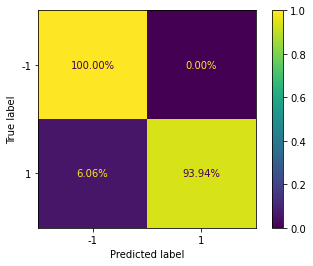

In [ ]:

from sklearn.metrics import plot_confusion_matrix
IC = type('IdentityClassifier', (), {"predict": lambda i : i, "_estimator_type": "classifier"})
plot_confusion_matrix(IC, y_pred, y_test, normalize='true', values_format='.2%');

In [ ]:
novel_index = where(y_pred == -1) 
novel_values = df2.iloc[novel_index]
novel_values

,Delay,Code_200,Code_201,Code_204,Code_302,Code_400,Code_404,Code_500,Y
4,17000,0,0,1,0,0,0,0,1
14,24000,0,0,1,0,0,0,0,1
44,21000,0,0,1,0,0,0,0,1
54,30000,0,0,1,0,0,0,0,1
85,20000,0,0,0,0,0,0,1,1
88,13000,0,0,0,1,0,0,0,1
91,52000,1,0,0,0,0,0,0,-1
94,52000,0,1,0,0,0,0,0,-1
97,42000,1,0,0,0,0,0,0,-1
100,72000,1,0,0,0,0,0,0,-1


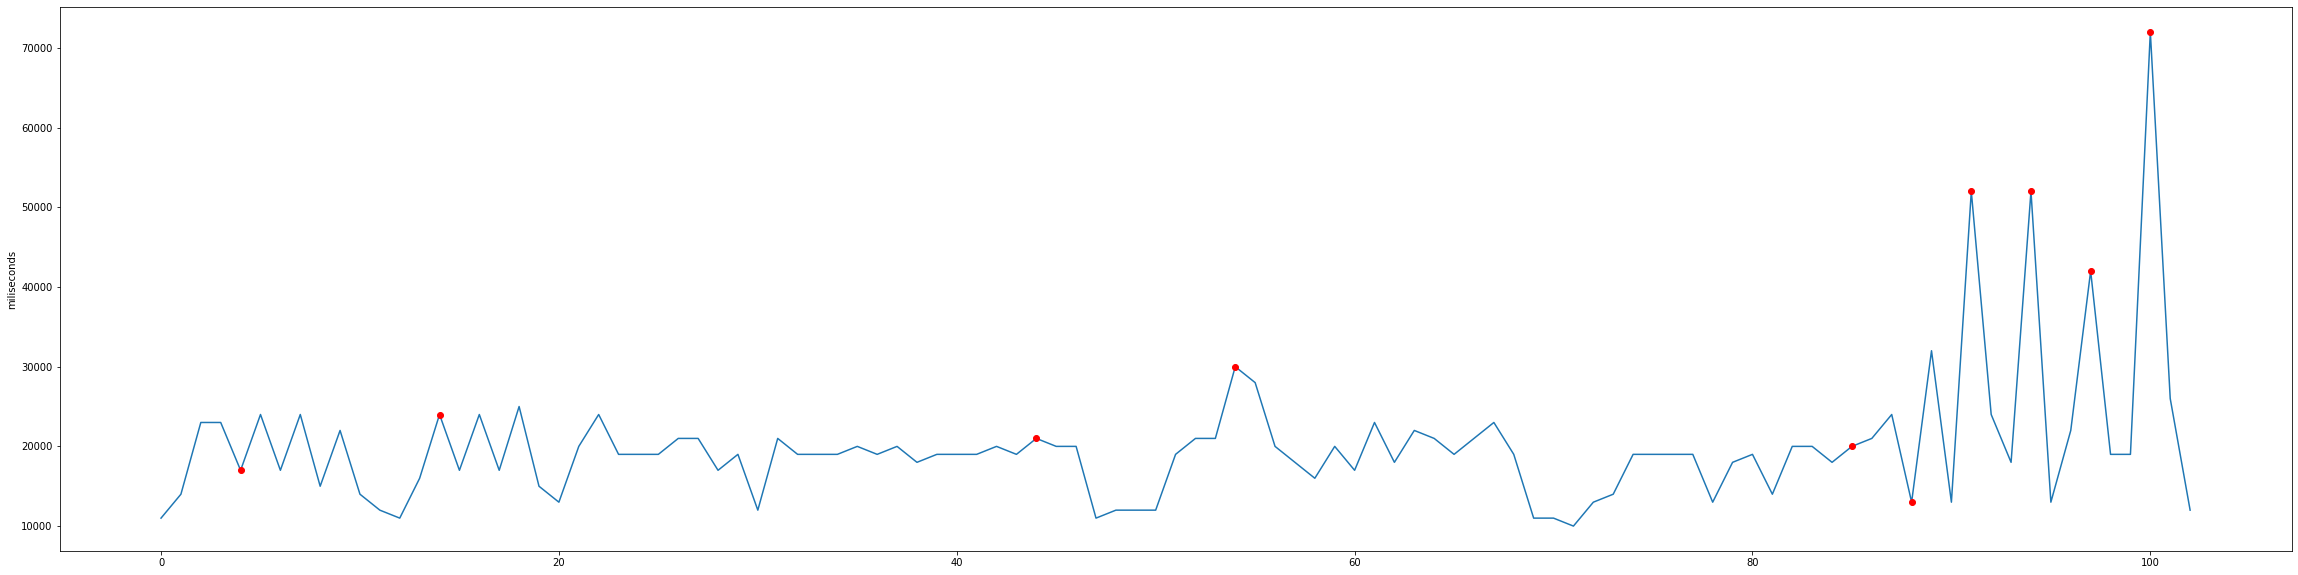

In [ ]:
import matplotlib.pyplot as plt
plt.rcParams["figure.figsize"] = (40,10)
plt.plot(df2['Delay'])
plt.plot(df2.iloc[novel_index]['Delay'],"ro")
plt.ylabel('miliseconds')
plt.show()